In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob as gb
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, add
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall, MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

2025-05-17 17:30:26.340741: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747503026.526399      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747503026.579424      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:

base_path = '/kaggle/input/pet-segmentation-dataset'

images_path = os.path.join(base_path, 'image')
masks_path  = os.path.join(base_path, 'mask')

image_files = sorted([f for f in os.listdir(images_path) if f.endswith('.jpg')])
mask_files  = sorted([f for f in os.listdir(masks_path) if f.endswith('.png')])

print("Number of images:", len(image_files))
print("Number of masks: ", len(mask_files))

print("\nSample image:", image_files[0])
print("Sample mask: ", mask_files[0])


Number of images: 1067
Number of masks:  1067

Sample image: 11141PET_jpg.rf.d40c7c019a088d65828ccd881af0207d.jpg
Sample mask:  11141PET_jpg.rf.d40c7c019a088d65828ccd881af0207d_mask.png


Image size: (640, 640)
Mask size : (640, 640)


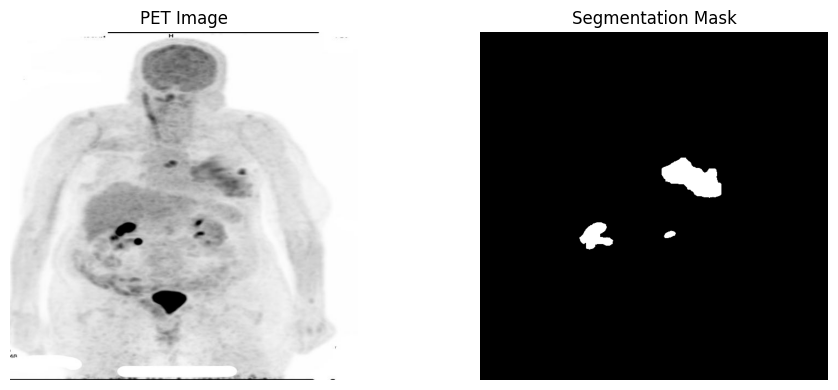

In [3]:

img_path = os.path.join(images_path, image_files[1002])
mask_path = os.path.join(masks_path, mask_files[1002])

image = Image.open(img_path).convert("RGB")
mask = Image.open(mask_path).convert("L")  

print("Image size:", image.size)  
print("Mask size :", mask.size)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("PET Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Segmentation Mask")
plt.axis("off")

plt.tight_layout()
plt.show()


In [4]:
def display_image_and_mask(n=5, seed=None):
    if seed is not None:
        np.random.seed(seed)

    fig, axs = plt.subplots(2, n, figsize=(20, 6))
    for i in range(n):
        idx = np.random.randint(0, len(image_files))
        
        img_path = os.path.join(images_path, image_files[idx])
        mask_path = os.path.join(masks_path, mask_files[idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        axs[0, i].imshow(img)
        axs[0, i].set_title(f'Image {idx}')
        axs[0, i].axis('off')

        axs[1, i].imshow(mask, cmap='gray')
        axs[1, i].set_title(f'Mask {idx}')
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()

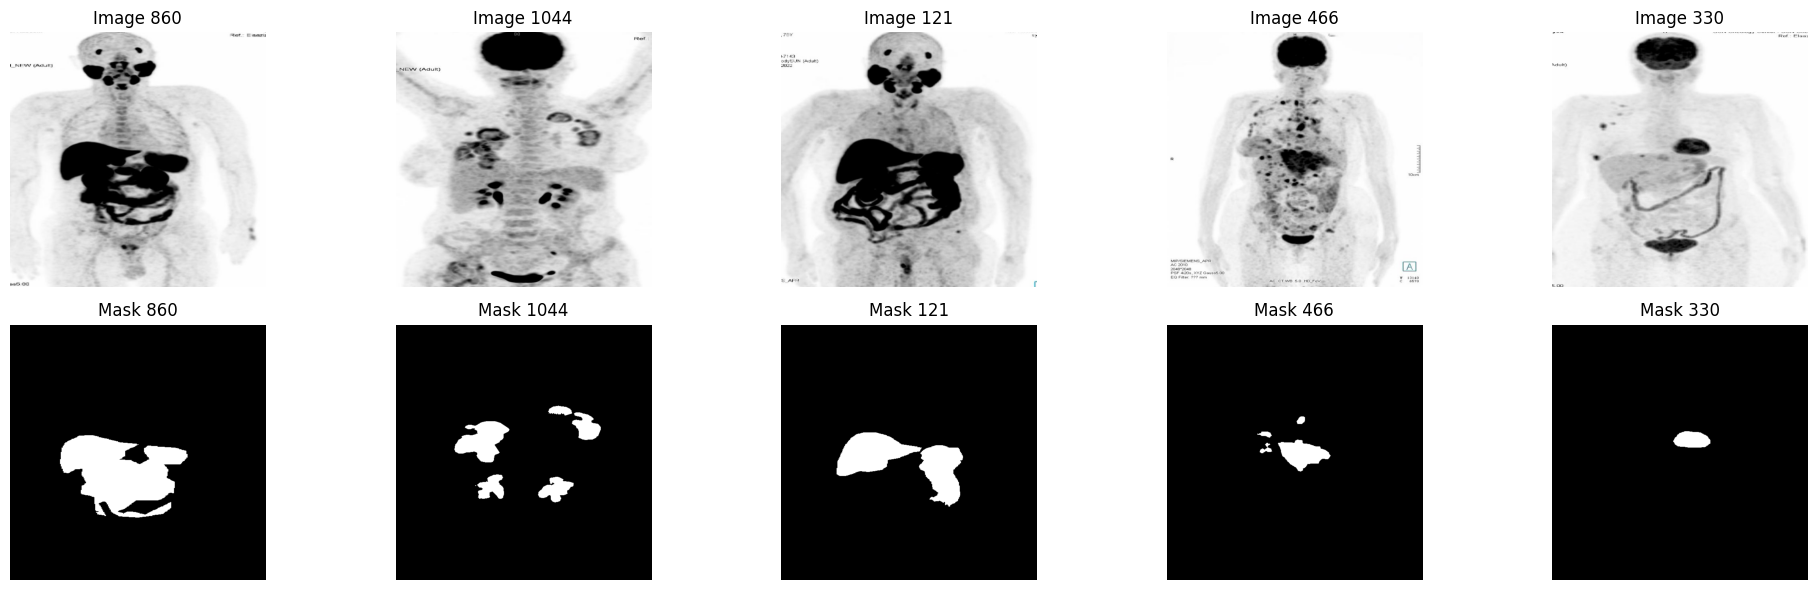

In [5]:
display_image_and_mask(n=5, seed=42)

In [6]:
def display_image_with_mask(n=5, seed=None):
    if seed is not None:
        np.random.seed(seed)

    fig, axs = plt.subplots(1, n, figsize=(20, 5))
    for i in range(n):
        idx = np.random.randint(0, len(image_files))
        
        img_path = os.path.join(images_path, image_files[idx])
        mask_path = os.path.join(masks_path, mask_files[idx])

        img_np = np.array(Image.open(img_path).convert("RGB"))
        mask_np = np.array(Image.open(mask_path).convert("L"))

        axs[i].imshow(img_np)
        axs[i].imshow(mask_np, cmap='Reds', alpha=0.5)
        axs[i].set_title(f'Overlay {idx}')
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


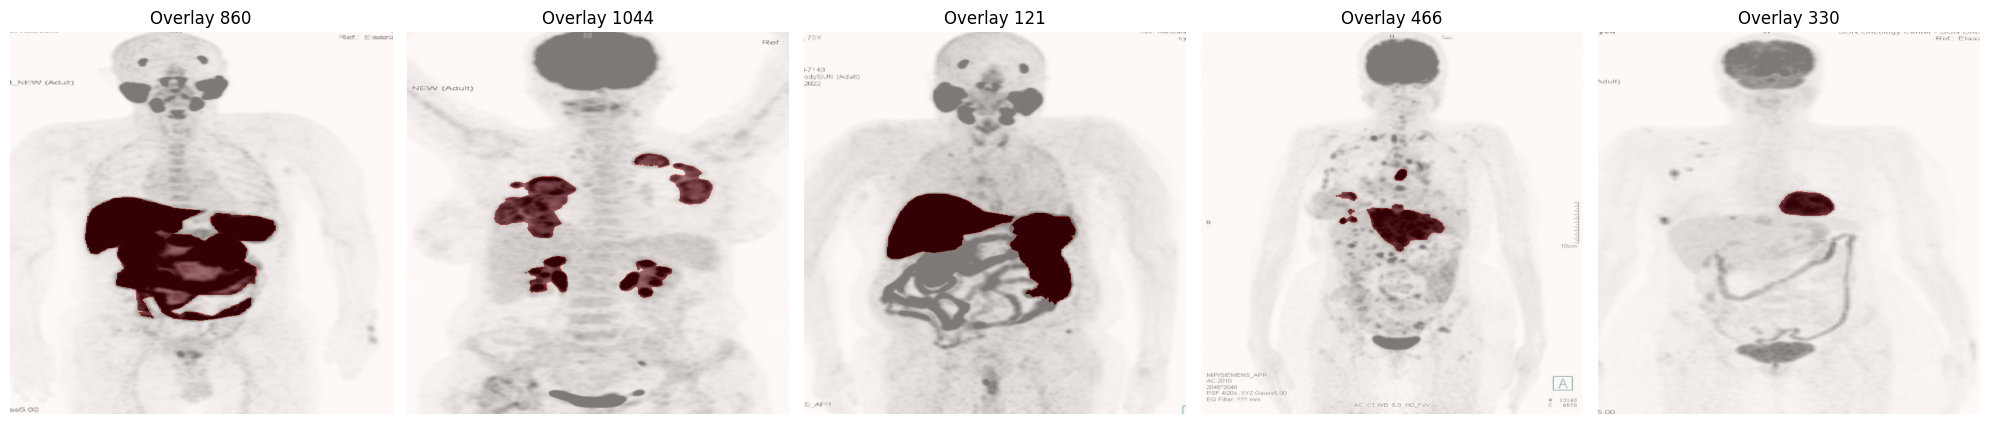

In [7]:
display_image_with_mask(n=5, seed=42)

In [8]:
image_modes = []
image_sizes = []
for f in image_files:
    img_path = os.path.join(images_path, f)
    img = Image.open(img_path)
    image_modes.append(img.mode)
    image_sizes.append(img.size)

from collections import Counter
print("Image modes:", Counter(image_modes))
print("Image sizes (top 5):", Counter(image_sizes).most_common(5))


Image modes: Counter({'RGB': 1067})
Image sizes (top 5): [((640, 640), 1067)]


In [9]:
# %% Install required packages
!pip install -qU torch torchvision torchsummary segmentation-models-pytorch albumentations matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 109.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [10]:
!pip install -U segmentation-models-pytorch

In [11]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.metrics import iou_score, f1_score
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from segmentation_models_pytorch.metrics import get_stats, iou_score, f1_score

In [12]:
class Config:
    # Data
    image_dir = "/kaggle/input/pet-segmentation-dataset/image"
    mask_dir = "/kaggle/input/pet-segmentation-dataset/mask"
    img_size = (640, 640)
    batch_size = 8  # Reduced for Kaggle memory constraints
    num_workers = 2
    
    # Model
    encoder_name = "resnet34"
    encoder_weights = "imagenet"
    activation = "sigmoid"
    
    # Training
    lr = 1e-4
    epochs = 50
    early_stop_patience = 7
    lr_patience = 3
    
    # Augmentation
    train_transform = A.Compose([
        A.Resize(640, 640),  # Explicit resize added
        A.Rotate(limit=15, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ElasticTransform(p=0.3),
        A.GridDistortion(p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),
        A.Blur(blur_limit=3, p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ], is_check_shapes=False)  # Disable shape checking as we force resize
    
    val_transform = A.Compose([
        A.Resize(640, 640),  # Explicit resize added
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ], is_check_shapes=False)

In [13]:
class PetSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = cv2.cvtColor(cv2.imread(self.image_paths[idx]), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        
        # Convert mask to binary and add channel dimension
        mask = (mask > 0).astype(np.float32)[..., None]  # Shape [H,W,1]
        
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            
        # Ensure mask has shape [1,H,W]
        mask = mask.permute(2, 0, 1) if mask.dim() == 3 else mask
        return image, mask

In [14]:
all_images = sorted([os.path.join(Config.image_dir, f) for f in os.listdir(Config.image_dir) if f.endswith('.jpg')])
all_masks = sorted([os.path.join(Config.mask_dir, f) for f in os.listdir(Config.mask_dir) if f.endswith('_mask.png')])

# Split data
train_images, test_images, train_masks, test_masks = train_test_split(
    all_images, all_masks, test_size=0.05, random_state=42
)
train_images, val_images, train_masks, val_masks = train_test_split(
    train_images, train_masks, test_size=0.1, random_state=42
)

# Create datasets
train_dataset = PetSegmentationDataset(train_images, train_masks, Config.train_transform)
val_dataset = PetSegmentationDataset(val_images, val_masks, Config.val_transform)
test_dataset = PetSegmentationDataset(test_images, test_masks, Config.val_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, num_workers=Config.num_workers)
val_loader = DataLoader(val_dataset, batch_size=Config.batch_size, shuffle=False, num_workers=Config.num_workers)
test_loader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False, num_workers=Config.num_workers)

In [15]:
# Shape verification
sample_image, sample_mask = next(iter(train_loader))
print(f"Image shape: {sample_image.shape}")  # Should be [B,3,H,W]
print(f"Mask shape: {sample_mask.shape}")    # Should be [B,1,H,W]
print(f"Unique mask values: {torch.unique(sample_mask)}")

Image shape: torch.Size([8, 3, 640, 640])
Mask shape: torch.Size([8, 1, 640, 640])
Unique mask values: tensor([0., 1.])


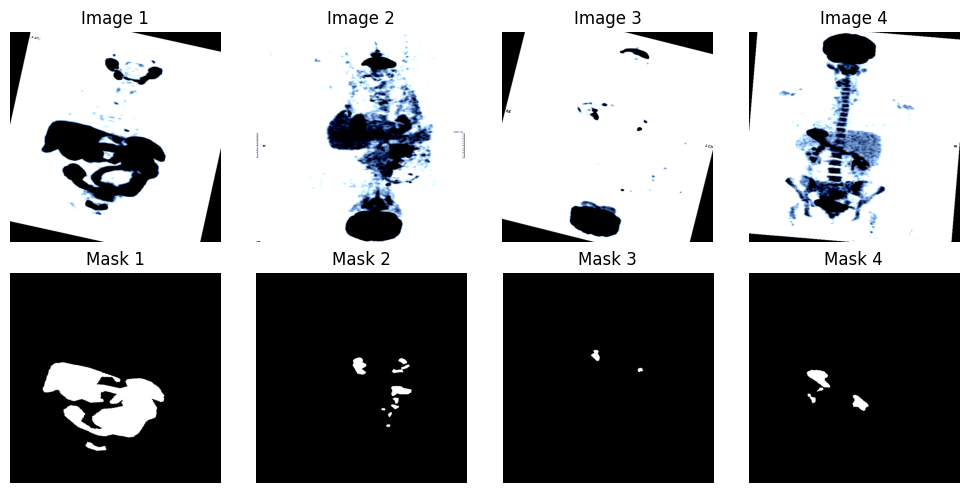

In [16]:
def show_batch(images, masks):
    plt.figure(figsize=(10, 5))
    for i in range(min(4, images.shape[0])):
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())
        plt.title(f"Image {i+1}")
        plt.axis('off')
        
        plt.subplot(2, 4, i+5)
        plt.imshow(masks[i][0].cpu().numpy(), cmap='gray')
        plt.title(f"Mask {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize first batch
images, masks = next(iter(train_loader))
show_batch(images, masks)

In [17]:
# %% Model Setup
model = smp.Unet(
    encoder_name=Config.encoder_name,
    encoder_weights=Config.encoder_weights,
    in_channels=3,
    classes=1,
    activation=None  # No activation - we handle it in loss
)


# Loss and Metrics
class StableDiceBCELoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
        
    def forward(self, logits, targets):
        # Ensure targets are in [0,1] range
        targets = torch.clamp(targets, 0.0, 1.0)
        
        # Calculate BCE with logits (more numerically stable)
        bce_loss = nn.functional.binary_cross_entropy_with_logits(
            logits, 
            targets,
            reduction='mean'
        )
        
        # Calculate Dice coefficient
        probs = torch.sigmoid(logits)
        intersection = (probs * targets).sum()
        dice_loss = 1 - (2. * intersection + self.smooth) / (probs.sum() + targets.sum() + self.smooth)
        
        return bce_loss + dice_loss

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [18]:
def plot_sample(image, mask, pred=None):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title('Image')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title('Ground Truth')
    
    if pred is not None:
        plt.subplot(1, 3, 3)
        plt.imshow(pred.squeeze(), cmap='gray')
        plt.title('Prediction')
    
    plt.show()

class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf
        
    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


criterion = StableDiceBCELoss()
optimizer = optim.AdamW(model.parameters(), lr=Config.lr, weight_decay=1e-4)
early_stopping = EarlyStopping(patience=Config.early_stop_patience)


best_iou = 0.0
train_losses = []
val_losses = []
val_iou_scores = []


In [20]:
# Add this before training to check your masks
sample_image, sample_mask = next(iter(train_loader))
print(f"Mask unique values: {torch.unique(sample_mask)}")
print(f"Mask value range: {sample_mask.min()}, {sample_mask.max()}")

Mask unique values: tensor([0., 1.])
Mask value range: 0.0, 1.0


In [21]:
for epoch in range(Config.epochs):
    model.train()
    running_loss = 0.0
    
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images = images.to(device)
        masks = masks.to(device)
        
        # Value sanity check
        assert torch.all(masks >= 0) and torch.all(masks <= 1), "Mask values out of range [0,1]"
        
        optimizer.zero_grad()
        outputs = model(images)
        
        # Verify output range
        if torch.isnan(outputs).any():
            raise ValueError("Model outputs contain NaN values")
            
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    total_intersection = 0.0
    total_union = 0.0
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            val_loss += criterion(outputs, masks).item() * images.size(0)
            
            # Calculate metrics
            preds = (torch.sigmoid(outputs) > 0.5).float()
            intersection = (preds * masks).sum()
            union = (preds + masks).sum() - intersection
            
            total_intersection += intersection.item()
            total_union += union.item()
    
    # Calculate metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_iou = total_intersection / (total_union + 1e-7)
    
    # Store metrics
    train_losses.append(epoch_loss)
    val_losses.append(val_epoch_loss)
    val_iou_scores.append(val_iou)
    
    print(f"Epoch {epoch+1}/{Config.epochs}")
    print(f"Train Loss: {epoch_loss:.4f} | Val Loss: {val_epoch_loss:.4f} | Val IoU: {val_iou:.4f}")
    
    # Save best model
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"New best model saved with IoU: {best_iou:.4f}")
    
    # Early stopping
    if early_stopping(val_epoch_loss):
        print("Early stopping triggered!")
        break

Epoch 1: 100%|██████████| 114/114 [00:46<00:00,  2.43it/s]


Epoch 1/50
Train Loss: 1.1955 | Val Loss: 1.0527 | Val IoU: 0.6774
New best model saved with IoU: 0.6774


Epoch 2: 100%|██████████| 114/114 [00:46<00:00,  2.45it/s]


Epoch 2/50
Train Loss: 0.9374 | Val Loss: 0.8628 | Val IoU: 0.7193
New best model saved with IoU: 0.7193


Epoch 3: 100%|██████████| 114/114 [00:46<00:00,  2.44it/s]


Epoch 3/50
Train Loss: 0.7488 | Val Loss: 0.7152 | Val IoU: 0.7474
New best model saved with IoU: 0.7474


Epoch 4: 100%|██████████| 114/114 [00:46<00:00,  2.47it/s]


Epoch 4/50
Train Loss: 0.5959 | Val Loss: 0.5450 | Val IoU: 0.7621
New best model saved with IoU: 0.7621


Epoch 5: 100%|██████████| 114/114 [00:46<00:00,  2.44it/s]


Epoch 5/50
Train Loss: 0.4643 | Val Loss: 0.4299 | Val IoU: 0.7712
New best model saved with IoU: 0.7712


Epoch 6: 100%|██████████| 114/114 [00:46<00:00,  2.45it/s]


Epoch 6/50
Train Loss: 0.3621 | Val Loss: 0.3544 | Val IoU: 0.7752
New best model saved with IoU: 0.7752


Epoch 7: 100%|██████████| 114/114 [00:46<00:00,  2.44it/s]


Epoch 7/50
Train Loss: 0.3047 | Val Loss: 0.3120 | Val IoU: 0.7629


Epoch 8: 100%|██████████| 114/114 [00:46<00:00,  2.46it/s]


Epoch 8/50
Train Loss: 0.2765 | Val Loss: 0.2937 | Val IoU: 0.7533


Epoch 9: 100%|██████████| 114/114 [00:46<00:00,  2.44it/s]


Epoch 9/50
Train Loss: 0.2440 | Val Loss: 0.2554 | Val IoU: 0.7733


Epoch 10: 100%|██████████| 114/114 [00:46<00:00,  2.47it/s]


Epoch 10/50
Train Loss: 0.2215 | Val Loss: 0.2498 | Val IoU: 0.7616


Epoch 11: 100%|██████████| 114/114 [00:46<00:00,  2.44it/s]


Epoch 11/50
Train Loss: 0.2102 | Val Loss: 0.2315 | Val IoU: 0.7696


Epoch 12: 100%|██████████| 114/114 [00:46<00:00,  2.47it/s]


Epoch 12/50
Train Loss: 0.1901 | Val Loss: 0.2114 | Val IoU: 0.7805
New best model saved with IoU: 0.7805


Epoch 13: 100%|██████████| 114/114 [00:46<00:00,  2.45it/s]


Epoch 13/50
Train Loss: 0.1892 | Val Loss: 0.2085 | Val IoU: 0.7794


Epoch 14: 100%|██████████| 114/114 [00:46<00:00,  2.48it/s]


Epoch 14/50
Train Loss: 0.1822 | Val Loss: 0.1940 | Val IoU: 0.7884
New best model saved with IoU: 0.7884


Epoch 15: 100%|██████████| 114/114 [00:46<00:00,  2.45it/s]


Epoch 15/50
Train Loss: 0.1711 | Val Loss: 0.2051 | Val IoU: 0.7769


Epoch 16: 100%|██████████| 114/114 [00:46<00:00,  2.47it/s]


Epoch 16/50
Train Loss: 0.1708 | Val Loss: 0.1961 | Val IoU: 0.7803


Epoch 17: 100%|██████████| 114/114 [00:46<00:00,  2.45it/s]


Epoch 17/50
Train Loss: 0.1686 | Val Loss: 0.2027 | Val IoU: 0.7705


Epoch 18: 100%|██████████| 114/114 [00:46<00:00,  2.47it/s]


Epoch 18/50
Train Loss: 0.1635 | Val Loss: 0.2166 | Val IoU: 0.7519


Epoch 19: 100%|██████████| 114/114 [00:46<00:00,  2.45it/s]


Epoch 19/50
Train Loss: 0.1571 | Val Loss: 0.1933 | Val IoU: 0.7781


Epoch 20: 100%|██████████| 114/114 [00:46<00:00,  2.47it/s]


Epoch 20/50
Train Loss: 0.1595 | Val Loss: 0.1983 | Val IoU: 0.7713


Epoch 21: 100%|██████████| 114/114 [00:46<00:00,  2.43it/s]


Epoch 21/50
Train Loss: 0.1572 | Val Loss: 0.2102 | Val IoU: 0.7609


Epoch 22: 100%|██████████| 114/114 [00:46<00:00,  2.45it/s]


Epoch 22/50
Train Loss: 0.1628 | Val Loss: 0.1913 | Val IoU: 0.7740


Epoch 23: 100%|██████████| 114/114 [00:46<00:00,  2.44it/s]


Epoch 23/50
Train Loss: 0.1508 | Val Loss: 0.1850 | Val IoU: 0.7848


Epoch 24: 100%|██████████| 114/114 [00:46<00:00,  2.44it/s]


Epoch 24/50
Train Loss: 0.1456 | Val Loss: 0.1913 | Val IoU: 0.7736


Epoch 25: 100%|██████████| 114/114 [00:46<00:00,  2.45it/s]


Epoch 25/50
Train Loss: 0.1452 | Val Loss: 0.1839 | Val IoU: 0.7805


Epoch 26: 100%|██████████| 114/114 [00:46<00:00,  2.47it/s]


Epoch 26/50
Train Loss: 0.1428 | Val Loss: 0.1769 | Val IoU: 0.7904
New best model saved with IoU: 0.7904


Epoch 27: 100%|██████████| 114/114 [00:46<00:00,  2.46it/s]


Epoch 27/50
Train Loss: 0.1363 | Val Loss: 0.1809 | Val IoU: 0.7854


Epoch 28: 100%|██████████| 114/114 [00:46<00:00,  2.44it/s]


Epoch 28/50
Train Loss: 0.1401 | Val Loss: 0.1934 | Val IoU: 0.7742


Epoch 29: 100%|██████████| 114/114 [00:46<00:00,  2.43it/s]


Epoch 29/50
Train Loss: 0.1413 | Val Loss: 0.1848 | Val IoU: 0.7832


Epoch 30: 100%|██████████| 114/114 [00:46<00:00,  2.46it/s]


Epoch 30/50
Train Loss: 0.1426 | Val Loss: 0.1884 | Val IoU: 0.7785


Epoch 31: 100%|██████████| 114/114 [00:46<00:00,  2.44it/s]


Epoch 31/50
Train Loss: 0.1385 | Val Loss: 0.2164 | Val IoU: 0.7499


Epoch 32: 100%|██████████| 114/114 [00:46<00:00,  2.46it/s]


Epoch 32/50
Train Loss: 0.1350 | Val Loss: 0.1857 | Val IoU: 0.7786


Epoch 33: 100%|██████████| 114/114 [00:46<00:00,  2.45it/s]


Epoch 33/50
Train Loss: 0.1309 | Val Loss: 0.1820 | Val IoU: 0.7789
Early stopping triggered!


In [22]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

test_loss = 0.0
total_tp = 0.0
total_fp = 0.0
total_fn = 0.0
total_tn = 0.0

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        test_loss += criterion(outputs, masks).item() * images.size(0)
        
        preds = (torch.sigmoid(outputs) > 0.5).float()
        
        # Confusion matrix
        tp = (preds * masks).sum()
        fp = (preds * (1 - masks)).sum()
        fn = ((1 - preds) * masks).sum()
        tn = ((1 - preds) * (1 - masks)).sum()
        
        total_tp += tp.item()
        total_fp += fp.item()
        total_fn += fn.item()
        total_tn += tn.item()

# Calculate metrics
epsilon = 1e-7
test_iou = total_tp / (total_tp + total_fp + total_fn + epsilon)
test_dice = 2 * total_tp / (2 * total_tp + total_fp + total_fn + epsilon)
test_loss /= len(test_loader.dataset)

print(f"\nTest Results:")
print(f"IoU: {test_iou:.4f}")
print(f"Dice: {test_dice:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Test Results:
IoU: 0.8025
Dice: 0.8905
Test Loss: 0.1702


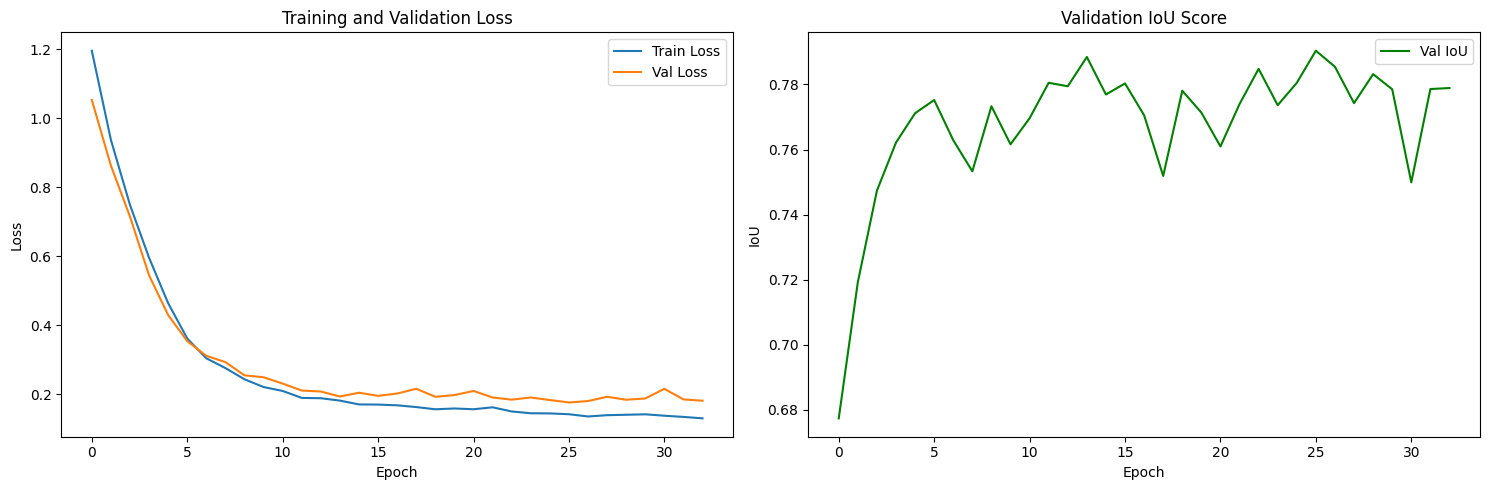

In [23]:
# Plot training curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_iou_scores, label='Val IoU', color='green')
plt.title('Validation IoU Score')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()

TypeError: iou_score() missing 2 required positional arguments: 'fn' and 'tn'

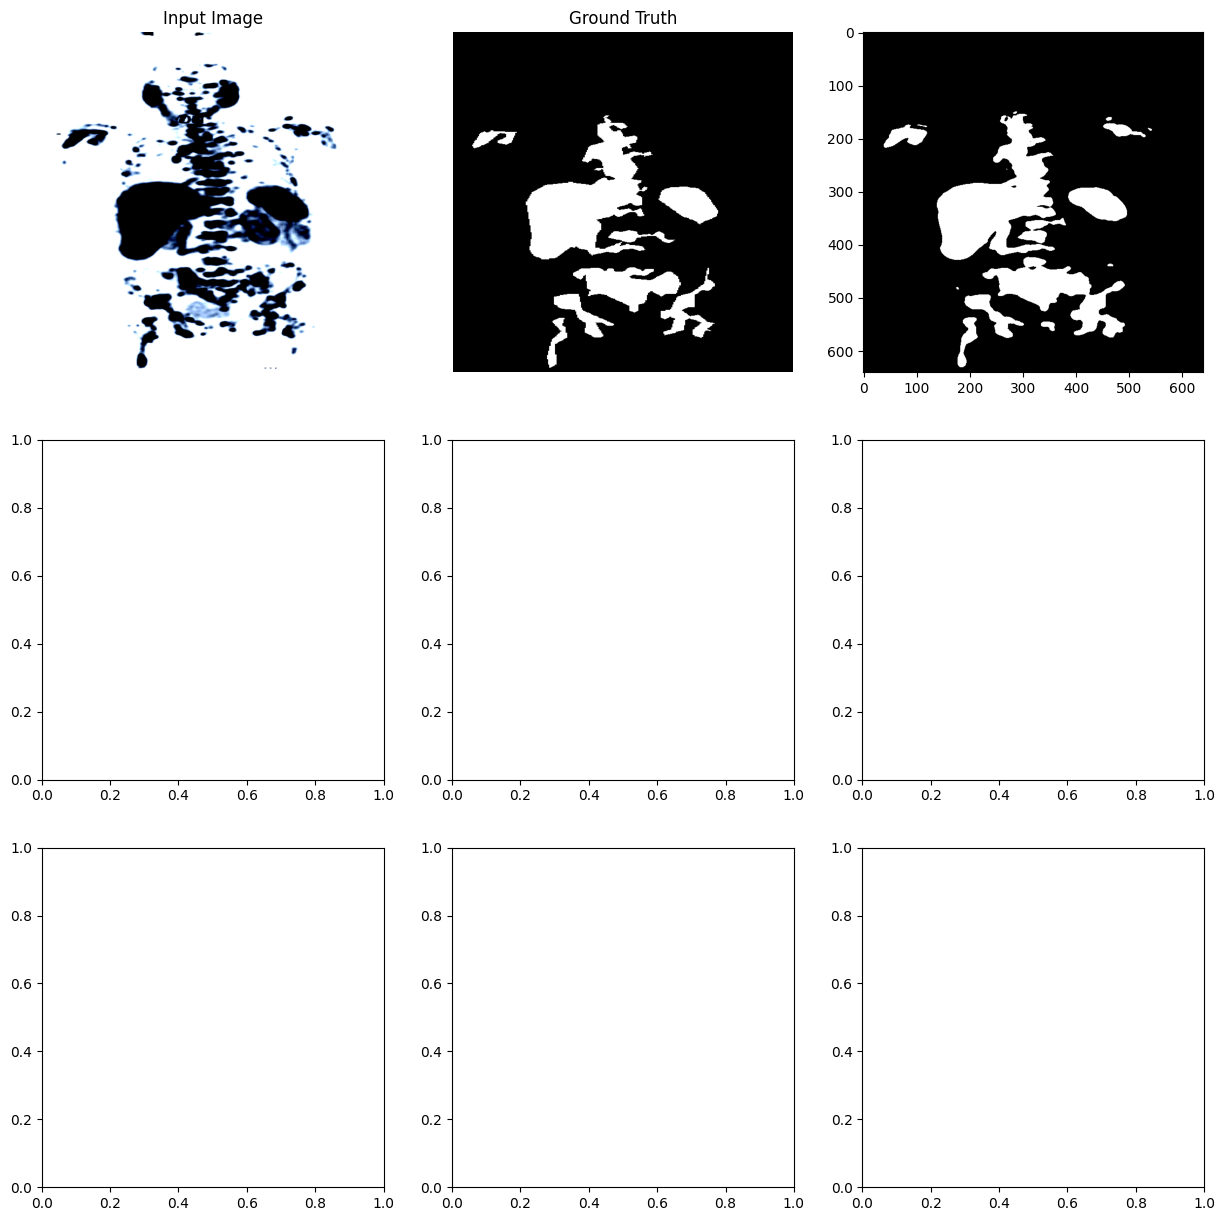

In [24]:
def visualize_predictions(model, loader, num_samples=3):
    model.eval()
    with torch.no_grad():
        images, masks = next(iter(loader))
        images = images.to(device)[:num_samples]
        masks = masks.to(device)[:num_samples]
        
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        
        fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples*5))
        if num_samples == 1:
            axes = axes.reshape(1, -1)
        
        for i in range(num_samples):
            # Original Image
            axes[i, 0].imshow(images[i].permute(1, 2, 0).cpu())
            axes[i, 0].set_title('Input Image')
            axes[i, 0].axis('off')
            
            # Ground Truth
            axes[i, 1].imshow(masks[i][0].cpu(), cmap='gray', vmin=0, vmax=1)
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')
            
            # Prediction
            axes[i, 2].imshow(preds[i][0].cpu(), cmap='gray', vmin=0, vmax=1)
            axes[i, 2].set_title(f'Prediction (IoU: {iou_score(preds[i], masks[i]):.2f})')
            axes[i, 2].axis('off')
        
        plt.tight_layout()
        plt.show()

# Visualize test predictions
visualize_predictions(model, test_loader, num_samples=3)

In [ ]:
print(f"\nClass Balance:")
print(f"True Positives: {total_tp:.0f}")
print(f"False Positives: {total_fp:.0f}")
print(f"False Negatives: {total_fn:.0f}")
print(f"True Negatives: {total_tn:.0f}")